In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import deepdish as dd
from imageio.v2 import imread

from colmap_utils.read_write_model import read_model, qvec2rotmat
from colmap_utils.read_dense import read_array

from tqdm import tqdm
from typing import Dict, List

# Util functions

In [3]:
def get_dataset_data(building: str, dataset_threshold: float = 0.4, print_info: bool = False):
    cameras, images, _ = read_model(path=building + "/dense/sparse" , ext='.bin')

    if print_info:
        print(f'Cameras: {len(cameras)}')
        print(f'Images: {len(images)}')

    pairs = dd.io.load(building + '/dense/stereo/pairs-dilation-0.00-fixed2.h5')
    if len(pairs[list(pairs.keys())[0]]) == 3:
        idx1, idx2 = 0, 1
    else:
        idx1, idx2 = 2, 3

    filtered = []
    for p in pairs:
        if pairs[p][idx1] >= dataset_threshold and pairs[p][idx2] >= dataset_threshold:
            filtered.append(p)
    
    if print_info:
        print(f'Valid pairs: {len(filtered)}/{len(pairs)}')
    pairs = filtered
    return pairs, cameras, images

In [4]:
def get_image(idx: int, building: str, images: Dict, cameras: Dict) -> Dict:
    im = imread(building + '/dense/images/' + images[idx].name)
    depth = read_array(building + '/dense/stereo/depth_maps/' + images[idx].name + '.photometric.bin')
    min_depth, max_depth = np.percentile(depth, [5, 95])
    depth[depth < min_depth] = min_depth
    depth[depth > max_depth] = max_depth

    q = images[idx].qvec
    R = qvec2rotmat(q)
    T = images[idx].tvec
    p = images[idx].xys
    pars = cameras[idx].params
    K = np.array([[pars[0], 0, pars[2]], [0, pars[1], pars[3]], [0, 0, 1]])
    pids = images[idx].point3D_ids
    v = pids >= 0

    return {
        'image': im,
        'K': K,
        'q': q,
        'R': R,
        'T': T,
        'xys': p,
        'ids': pids,
        'valid': v}


def skew_symmetric(t):
    return np.array([
        [0, -t[2], t[1]],
        [t[2], 0, -t[0]],
        [-t[1], t[0], 0]
    ])


def detect_keypoints_and_descriptors(image: np.ndarray, detector_type: str = 'ORB', n_features: int = 1024):
    """
    Detect keypoints and compute descriptors using a chosen detector
    
    Args:
        image: Input image (grayscale)
        detector_type: 'ORB' or 'SIFT'
        n_features: Maximum number of features to detect
    
    Returns:
        Dictionary with 'image', 'keypoints', 'descriptors'
    """
    if detector_type == 'ORB':
        detector = cv2.ORB_create(nfeatures=n_features)
    elif detector_type == 'SIFT':
        detector = cv2.SIFT_create(nfeatures=n_features)
    else:
        raise ValueError("Unsupported detector type. Use 'ORB' or 'SIFT'")
    
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    keypoints, descriptors = detector.detectAndCompute(image, None)
    
    return {
        'image': image,
        'keypoints': keypoints,
        'descriptors': descriptors
    }


def match_with_fundamental(data1, data2, F, threshold=3.0, bidirectional=True):
    """
    Match keypoints using fundamental matrix constraints
    
    Args:
        data1, data2: Dictionaries containing 'image', 'keypoints' (cv2.KeyPoint list)
        F: Fundamental matrix (3x3)
        threshold: Maximum epipolar distance in pixels
        bidirectional: Perform mutual consistency check
    
    Returns:
        List of cv2.DMatch objects representing valid matches
    """
    kpts1 = np.array([(kp.pt[0], kp.pt[1], 1) for kp in data1["keypoints"]])
    kpts2 = np.array([(kp.pt[0], kp.pt[1], 1) for kp in data2["keypoints"]])
    
    matches = []
    
    for i, kp1 in enumerate(kpts1):
        # Compute epipolar line in image2: l2 = F * kp1
        l2 = F @ kp1
        a, b, c = l2
        
        # Calculate distances for all keypoints in image2
        distances = np.abs(a*kpts2[:,0] + b*kpts2[:,1] + c) / np.sqrt(a**2 + b**2)
        
        # Find candidates within threshold
        candidates = np.where(distances < threshold)[0]
        if len(candidates) == 0:
            continue
            
        best_match = candidates[np.argmin(distances[candidates])]
        min_distance = distances[best_match]
        
        # Bidirectional consistency check
        if bidirectional:
            # Compute epipolar line in image1: l1 = F.T * kpt2
            l1 = F.T @ kpts2[best_match]
            a_rev, b_rev, c_rev = l1
            rev_distance = np.abs(a_rev * kp1[0] + b_rev * kp1[1] + c_rev) / np.sqrt(a_rev ** 2 + b_rev ** 2)
            if rev_distance > threshold:
                continue
                
        matches.append((i, best_match, min_distance))    
    return matches


def extract_fundamental(data1, data2):
    K1 = data1['K']
    K2 = data2['K']
    R1, T1 = data1['R'], data1['T']
    R2, T2 = data2['R'], data2['T']

    R = R2 @ R1.T
    T = T2 - R @ T1

    E = skew_symmetric(T) @ R
    F = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
    F /= np.linalg.norm(F)
    return F


def draw_matches_plt(data1, data2, matches, all_keypoints: bool = False, title='Fundamental Matrix Matches'):
    """
    Visualize matches using matplotlib
    
    Args:
        data1, data2: Dictionaries containing 'image' and 'keypoints'
        matches: List of cv2.DMatch objects
        title: Plot title
    """
    img1 = data1['image']
    img2 = data2['image']
    if len(img1.shape) == 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    if len(img2.shape) == 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
    
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    max_height = max(h1, h2)
    total_width = w1 + w2
    
    vis_image = np.zeros((max_height, total_width, 3), dtype=np.uint8)
    
    vis_image[:h1, :w1] = img1
    vis_image[:h2, w1:w1+w2] = img2
    
    _, ax = plt.subplots(figsize=(15, 7))
    ax.imshow(vis_image)
    ax.axis('off')
    ax.set_title(title)

    if all_keypoints:
        for pt1, pt2 in zip(data1['keypoints'], data2['keypoints']):
            pt1_coord = pt1.pt
            pt2_coord = pt2.pt

            ax.plot(pt1_coord[0], pt1_coord[1], 'ro', markersize=3)
            ax.plot(pt2_coord[0] + w1, pt2_coord[1], 'bo', markersize=3)
    
    for match in matches:
        try:
            pt1 = data1['keypoints'][match[0]].pt
            pt2 = data2['keypoints'][match[1]].pt
            
            pt2 = (pt2[0] + w1, pt2[1])
            
            ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'y-', linewidth=0.5, alpha=0.5)
            if not all_keypoints:
                ax.plot(pt1[0], pt1[1], 'ro', markersize=3)
                ax.plot(pt2[0], pt2[1], 'bo', markersize=3)
        except IndexError:
            continue 
    
    plt.tight_layout()
    plt.show()

# Dataset

In [5]:
building = "brandenburg_gate"
pairs, cameras, images = get_dataset_data(building, print_info=True)

Cameras: 1363
Images: 1363
Valid pairs: 224200/928203


Showing pair: (1352, 786)


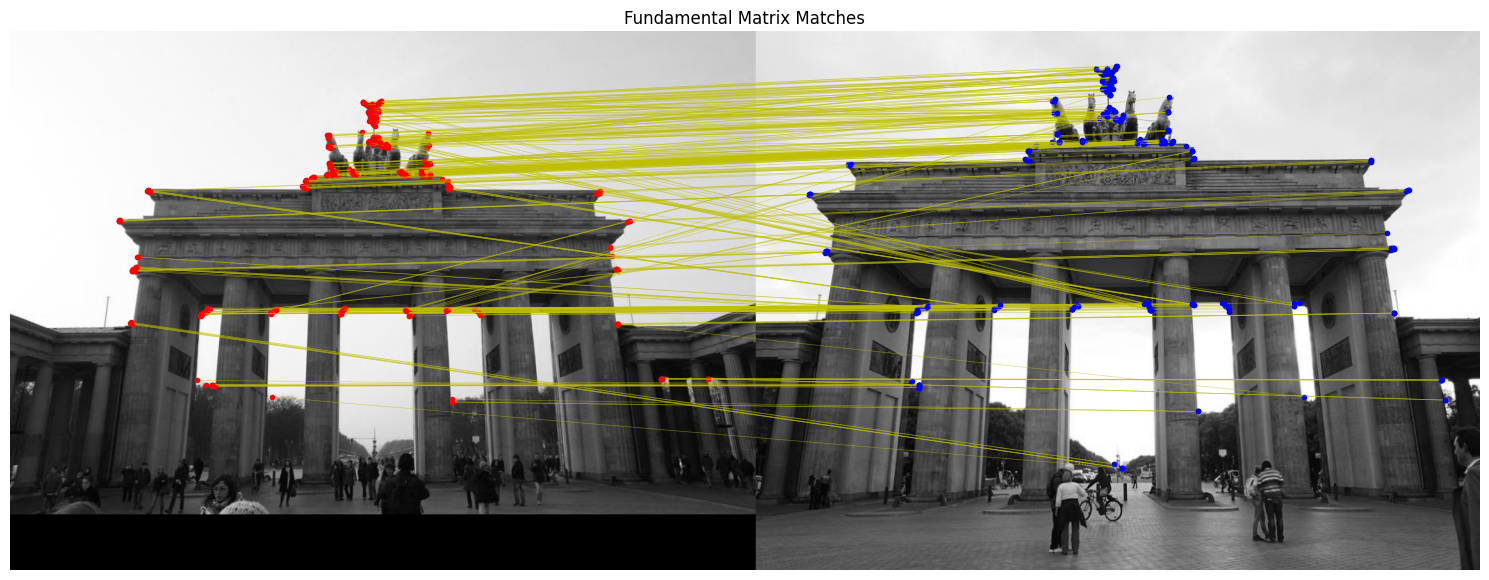

In [6]:
idx1, idx2 = pairs[5346]
print('Showing pair: ({}, {})'.format(idx1, idx2))
data1 = get_image(idx1, building, images, cameras)
data2 = get_image(idx2, building, images, cameras)

F = extract_fundamental(data1, data2)

data1_upd = detect_keypoints_and_descriptors(data1['image'], detector_type='ORB', n_features=512)
data2_upd = detect_keypoints_and_descriptors(data2['image'], detector_type='ORB', n_features=512)
matches = match_with_fundamental(data1_upd, data2_upd, F, threshold=1.0)
draw_matches_plt(data1_upd, data2_upd, matches, all_keypoints=False)

In [7]:
matches_arr = np.zeros(512) - 1
for match1, match2, _ in matches:
    matches_arr[match1] = match2
print(matches_arr[matches_arr == -1])

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [8]:
from torch.utils.data import Dataset

class MatchingDataset(Dataset):
    def __init__(self, datasets: List[str], 
                       detector_type: str = 'ORB', 
                       n_keypoints: int = 512,
                       dataset_part: float = 1.0,
                       max_pairs_per_dataset: int = -1,
                       allow_padding: bool = True):
        super().__init__()
        self.data: List[np.ndarray] = []
        self.labels: List[np.ndarray] = []
        self.desc_dim: int = 32 if detector_type == 'ORB' else 128

        zero_desc = np.zeros(self.desc_dim)
        skipped_samples = 0
        for building in datasets:
            print(f"Extracting {building} data...")
            pairs, cameras, images = get_dataset_data(building)

            np.random.shuffle(pairs)
            n = len(pairs) if max_pairs_per_dataset == -1 else max_pairs_per_dataset
            pairs = pairs[:min(n, int(dataset_part * len(pairs)))]

            for idx1, idx2 in tqdm(pairs, desc=f"Processing {building} image pairs"):
                data1 = get_image(idx1, building, images, cameras)
                data2 = get_image(idx2, building, images, cameras)

                F = extract_fundamental(data1, data2) 
                data1 = detect_keypoints_and_descriptors(data1['image'], detector_type=detector_type, n_features=n_keypoints)
                data2 = detect_keypoints_and_descriptors(data2['image'], detector_type=detector_type, n_features=n_keypoints)
                if not allow_padding and (len(data1["keypoints"]) < n_keypoints or len(data2["keypoints"]) < n_keypoints):
                    skipped_samples += 1
                    continue
        
                matches = match_with_fundamental(data1, data2, F, threshold=1.0)

                #input data
                padded = False
                sample = np.zeros((n_keypoints, 4 + 2 * self.desc_dim))  #n_keypoints x (2 keypoints1 + 2 keypoints2 + desc_dim desc1 + desc_dim desc2)
                for i in range(n_keypoints):
                    if i < len(data1["keypoints"]):
                        sample[i][0], sample[i][1] = data1["keypoints"][i].pt
                        sample[i][2:2 + self.desc_dim] = data1["descriptors"][i]
                    else:
                        padded = True
                        sample[i][0], sample[i][1] = 0.0, 0.0
                        sample[i][2:2 + self.desc_dim] = zero_desc

                    if i < len(data2["keypoints"]):
                        sample[i][2 + self.desc_dim], sample[i][3 + self.desc_dim] = data2["keypoints"][i].pt
                        sample[i][-self.desc_dim:] = data2["descriptors"][i]
                    else:
                        padded = True
                        sample[i][2 + self.desc_dim], sample[i][3 + self.desc_dim] = 0.0, 0.0
                        sample[i][-self.desc_dim:] = zero_desc

                if padded:
                    skipped_samples += 1


                #matches
                matches_arr = np.zeros(n_keypoints) - 1
                for match1, match2, _ in matches:
                    matches_arr[match1] = match2

                self.data.append(sample)
                self.labels.append(matches_arr)

        if allow_padding:
            print(f"Samples with padding: {skipped_samples}/{len(self.data)}")
        else:
            print(f"Skipped samples: {skipped_samples}/{len(self.data + skipped_samples)}")


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        return self.data[index], self.labels[index]

In [9]:
np.random.seed(42)
matching_dataset = MatchingDataset(["brandenburg_gate", "buckingham_palace", "sacre_coeur", "st_pauls_cathedral"], max_pairs_per_dataset=100)

Extracting brandenburg_gate data...


Processing brandenburg_gate image pairs: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Extracting buckingham_palace data...


Processing buckingham_palace image pairs: 100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


Extracting sacre_coeur data...


Processing sacre_coeur image pairs: 100%|██████████| 100/100 [00:06<00:00, 14.39it/s]


Extracting st_pauls_cathedral data...


Processing st_pauls_cathedral image pairs: 100%|██████████| 100/100 [00:06<00:00, 15.16it/s]

Samples with padding: 5/400
